In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


# Loading the data

In [3]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [4]:
# Loading the train and validation data sets and their outcomes
data_train = pd.read_parquet('./data_processed/set-a.parquet')
data_validate = pd.read_parquet('data_processed/set-b.parquet')
data_test = pd.read_parquet('./data_processed/set-c.parquet')

outcomes_train = pd.read_csv('./data/Outcomes-a.txt')
outcomes_train = outcomes_train.loc[:, ['RecordID', 'In-hospital_death']].set_index('RecordID')
outcomes_validate = pd.read_csv('./data/Outcomes-b.txt')
outcomes_validate = outcomes_validate.loc[:, ['RecordID', 'In-hospital_death']].set_index('RecordID')
outcomes_test = pd.read_csv('./data/Outcomes-c.txt')
outcomes_test = outcomes_test.loc[:, ['RecordID', 'In-hospital_death']].set_index('RecordID')

In [5]:
min_max_cols = ['Age', 'DiasABP', 'FiO2', 'GCS', 'Gender', 'Glucose', 'HCO3', 'HCT', 'HR', 
                'Height', 'K', 'MAP', 'NIDiasABP','NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 
                'RespRate', 'SysABP', 'Temp', 'Weight', 'Albumin', 'Cholesterol', 'MechVent'] 
log_min_max_cols = data_train.columns.drop(min_max_cols).drop(['RecordID', 'Time'])
print(len(min_max_cols))
print(len(log_min_max_cols))

25
16


In [6]:
# Min-max scaling
scaler = MinMaxScaler()
data_train_scaled = data_train.copy()
data_train_scaled[data_train_scaled.columns.drop(['RecordID', 'Time'])] = scaler.fit_transform(data_train[data_train.columns.drop(['RecordID', 'Time'])])

data_val_scaled = data_validate.copy()
data_val_scaled[data_val_scaled.columns.drop(['RecordID', 'Time'])] = scaler.fit_transform(data_validate[data_validate.columns.drop(['RecordID', 'Time'])])

data_test_scaled = data_test.copy()
data_test_scaled[data_test_scaled.columns.drop(['RecordID', 'Time'])] = scaler.fit_transform(data_test[data_test.columns.drop(['RecordID', 'Time']).values])

# Defining useful functions

In [7]:
def convert_data_to_tensor(features, outcomes, device='cpu'):
    """
    Converts tabular time-series features and outcome labels into PyTorch tensors suitable for LSTM input.

    This function groups the input data by 'RecordID' to form sequences for each individual record,
    drops unnecessary columns ('RecordID' and 'Time'), and stacks them into a batch of sequences.
    Corresponding outcome labels are matched using the 'RecordID' index.

    Parameters:
    -----------
    features : pandas.DataFrame
        A DataFrame containing time-series feature values. Expected to include:
            - 'RecordID' column: identifies each individual sequence (e.g., a patient or entity).
            - 'Time' column: time ordering of observations (dropped during tensor creation).
            - Remaining columns: actual input features.

    outcomes : pandas.DataFrame
        A DataFrame containing binary or continuous outcome labels, indexed by 'RecordID'.
        Each unique 'RecordID' should appear once and map to a single label.

    device : str, optional (default='cpu')
        The device to move the output tensors to (e.g., 'cuda', 'mps', or 'cpu').

    Returns:
    --------
    features_batch : torch.Tensor
        A 3D tensor of shape (batch_size, seq_length, input_size), where:
            - batch_size: number of unique RecordIDs (i.e., sequences).
            - seq_length: number of time steps for each record (can vary if padded later).
            - input_size: number of input features per time step.

    targets_batch : torch.Tensor
        A 2D tensor of shape (batch_size, 1), containing one target label per sequence.
    """
    all_sequences = []
    all_targets = []
    
    for ID in features['RecordID'].unique():
        features_df = features.loc[features['RecordID'] == ID, :].drop(['RecordID', 'Time'], axis=1)
        features_tensor = torch.tensor(features_df.values, dtype=torch.float32)

        target = torch.tensor(outcomes.loc[ID].values).float()

        all_sequences.append(features_tensor)
        all_targets.append(target)
    
    features_batch = torch.stack(all_sequences)
    targets_batch = torch.stack(all_targets)
    
    return features_batch.to(device), targets_batch.to(device)

In [75]:
class Classifier(nn.Module):
    """
    A simple LSTM-based binary classifier.

    Args:
        input_size (int): Number of input features per time step.
        hidden_size (int): Number of features in the LSTM hidden state.
        bidirectional (bool, optional): If True, uses a bidirectional LSTM. Defaults to False.
    """
    def __init__(self, input_size, hidden_size, bidirectional=False):
        super(Classifier, self).__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=bidirectional)
        self.classifier = nn.Linear(1, 1)  # Final linear layer expects 1-dimensional input

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input tensor of shape (seq_len, batch_size, input_size).

        Returns:
            Tensor: Output logits of shape (batch_size, 1).
        """
        x, _ = self.lstm(x)  # Run input through LSTM

        if self.bidirectional:
            # If bidirectional, average across hidden units and reshape to (batch_size, 1)
            x = (x[:, 0, -1] + x[:, -1, 0]) / 2
            x = x.mean(axis=1).reshape(x.shape[0], 1)
        else:
            x = x[:, -1, :]      # Take output from the last time step


        return self.classifier(x)  # Pass through final linear layer


In [9]:
def train_model(model, criterion, X_train, y_train, X_val, y_val, initial_parameter=None, num_epochs=100):
    """
    Trains a PyTorch model using a given loss criterion and optimizer, and evaluates on a validation set.

    Args:
        model (nn.Module): The PyTorch model to train.
        criterion (nn.Module): Loss function, e.g., nn.BCEWithLogitsLoss().
        X_train (Tensor): Training input features (Tensor).
        y_train (Tensor): Training labels (Tensor).
        X_val (Tensor): Validation input features (Tensor).
        y_val (Tensor): Validation labels (Tensor).
        initial_parameter (float, optional): If specified, fills all model parameters with this value before training.
        num_epochs (int): Number of training epochs. Default is 100.

    Returns:
        Tuple:
            - model (nn.Module): The trained model.
            - metrics (dict): Dictionary containing training/validation losses, accuracies, AUROCs, and AUPRCs.
    """
    # Ensure labels are 1D
    y_train = y_train.squeeze()
    y_val = y_val.squeeze()
    
    # Convert validation labels to numpy once (for metric computation)
    y_val_numpy = y_val.cpu().numpy()
    
    # Metrics to collect during training
    train_losses = []
    val_losses = []
    accuracies = []
    aurocs = []
    auprcs = []

    # Optional: initialize all model parameters to a fixed value
    if initial_parameter != None:
        with torch.no_grad():
            for param in model.parameters():
                param.fill_(initial_parameter)
                param.requires_grad_(True)

    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters())

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        y_pred = model(X_train).squeeze()  # Forward pass on training data

        loss = criterion(y_pred, y_train)  # Compute training loss
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        y_pred = model(X_val).squeeze()  # Forward pass on validation data

        loss = criterion(y_pred, y_val)  # Compute validation loss
        val_losses.append(loss.item())

        # Compute metrics
        predictions = torch.sigmoid(y_pred).round().detach().cpu().numpy()
        accuracies.append(accuracy_score(y_val_numpy, predictions))
        aurocs.append(roc_auc_score(y_val_numpy, predictions))
        auprcs.append(average_precision_score(y_val_numpy, predictions))

        # Early stopping logic placeholder (commented out)
        # if best_val_loss - loss < 1e-3:
        #     break
        # else:
        #     best_val_loss = loss
        
    return model, {
        'train losses': train_losses,
        'val losses': val_losses,
        'accuracies': accuracies,
        'aurocs': aurocs,
        'auprcs': auprcs
    }


In [10]:
def test_model(model, criterion, X_test, y_test):
    """
    Evaluates a trained model on a test dataset using various binary classification metrics.

    Args:
        model (nn.Module): The trained PyTorch model.
        criterion (nn.Module): Loss function used during evaluation, e.g., nn.BCEWithLogitsLoss().
        X_test (Tensor): Test input features.
        y_test (Tensor): Test labels.

    Returns:
        Tuple:
            - loss (Tensor): Loss value on the test set.
            - accuracy (float): Classification accuracy.
            - auroc (float): Area under the ROC curve.
            - auprc (float): Area under the precision-recall curve.
            - conf_matrix (ndarray): Confusion matrix as a NumPy array.
    """
    # Ensure labels are 1D
    y_test = y_test.squeeze()
    
    # Store a NumPy version of the ground truth labels for metric computation
    y_test_numpy = y_test.cpu().numpy()

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for evaluation
        y_pred = model(X_test).squeeze()  # Forward pass on test data

        loss = criterion(y_pred, y_test)  # Compute test loss

        # Apply sigmoid to logits, round to binary predictions, convert to NumPy
        predictions = torch.sigmoid(y_pred).round().cpu().numpy()

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test_numpy, predictions)
        auroc = roc_auc_score(y_test_numpy, predictions)
        auprc = average_precision_score(y_test_numpy, predictions)
        conf_matrix = confusion_matrix(y_test_numpy, predictions)

    return loss, accuracy, auroc, auprc, conf_matrix


# Creating LSTM with BCEWithLogitsLoss

In [21]:
X_train_val, y_train_val = convert_data_to_tensor(pd.concat([data_test_scaled, data_val_scaled]), pd.concat([outcomes_test, outcomes_validate]), device)

In [18]:
X_train, y_train = convert_data_to_tensor(data_train_scaled, outcomes_train, device)
X_val, y_val = convert_data_to_tensor(data_val_scaled, outcomes_validate, device)
X_test, y_test = convert_data_to_tensor(data_test_scaled, outcomes_test, device)

In [91]:
model = Classifier(41, 1, bidirectional=True).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=(y_train.shape[0] - y_train.sum()) / y_train.sum())

In [98]:
trained_model, metrics = train_model(model, criterion, X_train_val, y_train_val, X_val, y_val, initial_parameter=None, num_epochs=500)
print(f'Accuracy: {metrics["accuracies"][-1]:.4f}, AuROC: {metrics["aurocs"][-1]:.4f}, AuPRC: {metrics["auprcs"][-1]:.4f}\n')

100%|█████████████████████████████████████████| 500/500 [04:14<00:00,  1.97it/s]

Accuracy: 0.7438, AuROC: 0.7677, AuPRC: 0.2949



In [154]:
trained_model, metrics = train_model(model, criterion, X_train, y_train, X_val, y_val, initial_parameter=0.1, num_epochs=1000)
print(f'Accuracy: {metrics["accuracies"][-1]:.4f}, AuROC: {metrics["aurocs"][-1]:.4f}, AuPRC: {metrics["auprcs"][-1]:.4f}\n')

100%|███████████████████████████████████████| 1000/1000 [05:21<00:00,  3.11it/s]

Accuracy: 0.7430, AuROC: 0.7577, AuPRC: 0.2874



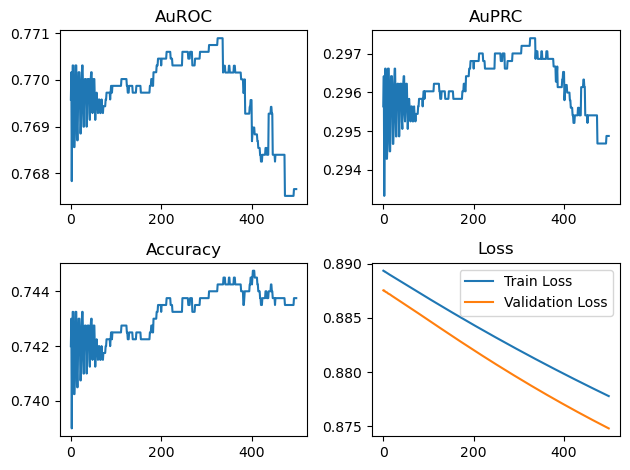

In [99]:
plt.subplot(2, 2, 1)
plt.plot(metrics['aurocs'])
plt.title('AuROC')

plt.subplot(2, 2, 2)
plt.plot(metrics['auprcs'])
plt.title('AuPRC')

plt.subplot(2, 2, 3)
plt.plot(metrics['accuracies'])
plt.title('Accuracy')

plt.subplot(2, 2, 4)
plt.plot(metrics['train losses'], label='Train Loss')
plt.plot(metrics['val losses'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [100]:
test_loss, test_accuracy, test_auroc, test_auprc, test_conf_matrix = test_model(trained_model, criterion, X_test, y_test)
print(f'Loss: {test_loss:.4f}\nAccuracy: {test_accuracy:.4f}\nAuROC: {test_auroc:.4f}\nAuPRC: {test_auprc:.4f}')

Loss: 0.8807
Accuracy: 0.7480
AuROC: 0.7646
AuPRC: 0.3011


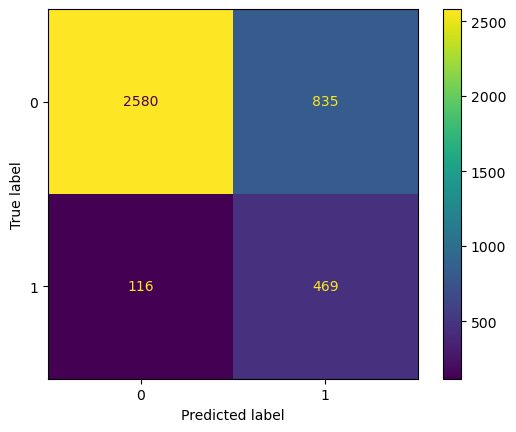

In [50]:
ConfusionMatrixDisplay(test_conf_matrix).plot()
plt.show()

In [162]:
torch.save(model.state_dict(), './trained_models/something')

In [88]:
t=torch.randn(2, 3, 4)
t

tensor([[[-0.0154, -0.3809, -0.6100,  2.8457],
         [-0.6623,  0.3309, -0.6061, -0.8032],
         [ 1.1064, -0.8233, -0.5121, -0.1345]],

        [[ 0.7689,  0.5388, -0.4201, -0.4836],
         [ 0.8126, -0.6876,  0.7701, -0.3811],
         [ 0.7207,  0.6148, -1.2801, -0.1981]]])

In [90]:
((t[:, -1, 0] + t[:, 0, -1]) / 2).shape[0]

2